In [1]:
!pip install parameter-sherpa

In [1]:
import sherpa

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("owid-covid-data.csv")
data = data[data.iso_code=="FRA"]
data = data[data.date>='2020-03-01'] # primeiros casos computados
data.reset_index(inplace=True)

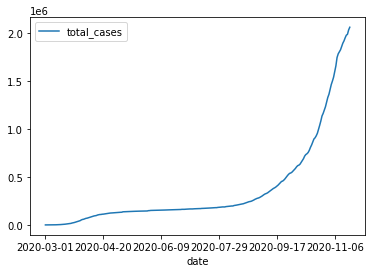

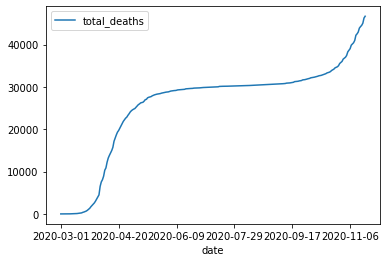

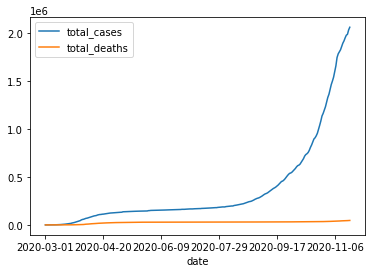

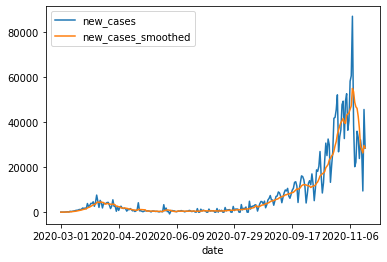

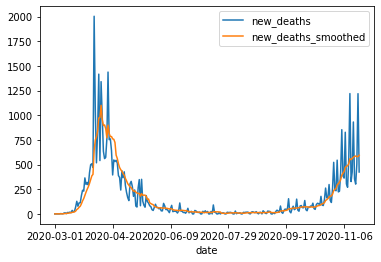

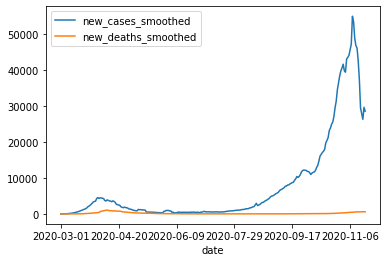

In [14]:
data.set_index('date')[['total_cases']].plot()#.save('t_cases.png')
data.set_index('date')[['total_deaths']].plot()#.save('t_deaths.png')

data.set_index('date')[['total_cases','total_deaths']].plot()#.save('t_cases_deaths.png')

data.set_index('date')[['new_cases','new_cases_smoothed']].plot()#.save('n_cases.png')
data.set_index('date')[['new_deaths','new_deaths_smoothed']].plot()#.save('n_cases.png')

data.set_index('date')[['new_cases_smoothed','new_deaths_smoothed']].plot()#.save('n_cases_deaths.png')

popFRA = 67*10^6 

In [15]:
def ODE (t,y,params):
    S,E,I,A,R,D = y
    lambda_,alpha,p,theta,gamma, mu,mu1,mu2, t1,t2 = params

    # transição de mu1 para mu2, mudança de perfil dos infectados, com inflexão em t2, flexibilização do Lockdown
    mu = ( ( (np.tanh(-t + t2) + 1 )/2 ) * abs(mu1 - mu2) ) + mu2
    
    # período de isolamento com queda de lambda_ com inflexões em t1 e t2, início e fim do lockdown respectivamente
    lambda_ = lambda_ * (1 - ((1 + np.tanh(t - t1)) / 2) * ((1 - np.tanh(t - t2) / 2) ) )
    
    return [-lambda_*S*I,
            lambda_*S*I - alpha*E,
            (1-p)*alpha*E - gamma*I - mu*I,
            p*alpha*E - theta*A,
            gamma*I + theta*A,
            mu*I ]

In [16]:
T = ode_solver()
T.function = ODE
T.algorithm='rk8pd'
eps = 0.0001
inits = [1-eps, 0, eps, 0, 0, 0]
tspan = [0,300]
T.ode_solve(tspan, inits, num_points=300, params=[0.1,0.1,0.1,0.1,0.4,0.1,0.1,0.1,54,109])

In [17]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[9.99900000e-01, 0.00000000e+00, 1.00000000e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [9.99892120e-01, 7.46805282e-06, 6.09665563e-05, 3.97925523e-08,
        3.15247792e-05, 7.88084364e-06],
       [9.99887288e-01, 1.13371047e-05, 3.76712071e-05, 1.27931524e-07,
        5.08624045e-05, 1.27132151e-05],
       ...,
       [9.99875734e-01, 3.44058819e-17, 7.53507146e-18, 3.33507312e-17,
        9.98980685e-05, 2.43678687e-05],
       [9.99875734e-01, 3.14744605e-17, 6.89307456e-18, 3.04900174e-17,
        9.98980685e-05, 2.43678687e-05],
       [9.99875734e-01, 2.87927997e-17, 6.30577655e-18, 2.78748661e-17,
        9.98980685e-05, 2.43678687e-05]])

In [18]:
@interact
def plot_sol(lambda_ = (0.,1.,.01),
             alpha = (0.,1,.01),
             p = (.1,.9,.05),
             theta = (0.,1.,.05),
             gamma = (0.,1.,.01),
             mu = (0.,.1,.01),
             mu1 = (0.,.1,.01),
             mu2 = (0.,.1,.01),
             t1 = (50,60,1),
             t2 = (100,120,1)):
                
    T = ode_solver()
    T.function = ODE
    T.algorithm='rk8pd'
    inits = [.99, 0,.001, 0, 0, 0]
    tspan = [0,300]
    T.ode_solve(tspan, inits, num_points=300,
            params=[lambda_, alpha,p,theta,gamma, mu,mu1,mu2,t1,t2])
    
    sim = np.array([y for t,y in T.solution])
    
    r = list_plot(sim[:len(data),-2],color='red',legend_label='R', plotjoined=True)
    d = list_plot(sim[:len(data),-1],color='purple', legend_label='D', plotjoined=True)
    
    cases = list_plot(list(zip(range(1,len(data)),data.total_cases/popFRA)), color='black',legend_label='cases(obs)')
    deaths = list_plot(list(zip(range(1,len(data)),data.total_deaths/popFRA)), color='orange',legend_label='deaths(obs)')
    
    show(r+cases)
    show(d+deaths)

Interactive function <function plot_sol at 0x7f5800e58830> with 10 widgets
  lambda_: FloatSlider(value=0.5, d…

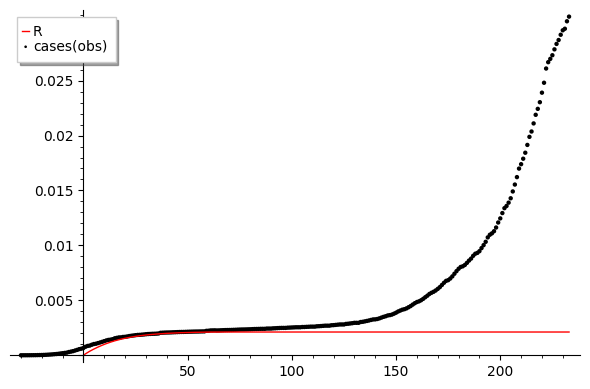

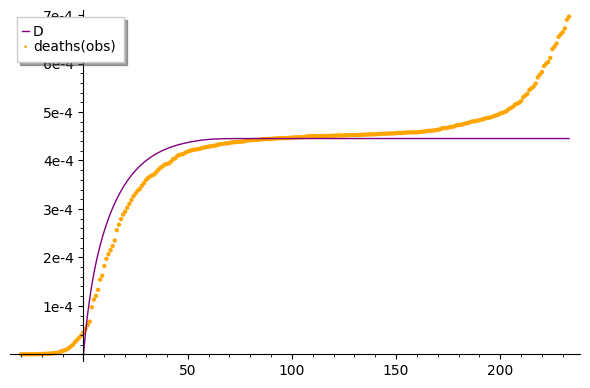

In [21]:
# valores dos parâmetros obtidos pelo interact
def plot_sol(lambda_ = 0.18,
             alpha = 0.2,
             p = 0.5,
             theta = 0.5,
             gamma = 0.15,
             mu = 0.05,
             mu1 = 0.05,
             mu2 = 0.05,
             t0 = -30,
             t1 = 55,
             t2 = 110):
    
    T = ode_solver()
    T.function = ODE
    T.algorithm='rk8pd'
    inits = [.99, 0,.001, 0, 0, 0]
    tspan = [0,300]
    T.ode_solve(tspan, inits, num_points=300,
            params=[lambda_, alpha,p,theta,gamma, mu,mu1,mu2,t1,t2])
    
    sim = np.array([y for t,y in T.solution])
    
    r = list_plot(sim[: len(data)+t0 ,-2],color='red',legend_label='R', plotjoined=True)
    d = list_plot(sim[: len(data)+t0 ,-1],color='purple', legend_label='D', plotjoined=True)
    
    cases = list_plot(list(zip( range(t0,len(data)+t0) ,data.total_cases/popFRA)), color='black',legend_label='cases(obs)')
    deaths = list_plot(list(zip( range(t0,len(data)+t0) ,data.total_deaths/popFRA)), color='orange',legend_label='deaths(obs)')
    
    show(r+cases)
    show(d+deaths)
    
plot_sol()

------------------------------------------------------------------------------------------------------------------------

In [221]:
parameters = [
    sherpa.Continuous(name='lambda_',range=[0.15,.2]), 
    sherpa.Continuous(name='alpha',range=[0.1,0.3]), 
    sherpa.Continuous(name='p',range=[0.4,0.6]),
    sherpa.Continuous(name='theta',range=[.5,.5]),
    sherpa.Continuous(name='gamma',range=[0.,2.]),
    sherpa.Continuous(name='mu',range=[.1,.1]),
    sherpa.Continuous(name='mu1',range=[.01,.09]),
    sherpa.Continuous(name='mu2',range=[.01,.09]),
    sherpa.Discrete(name='t2',range=[108,112]), # quando a flexibilização afetou a dinâmica
    sherpa.Discrete(name='t1',range=[54,56]), # quando o isolamento afetou a dinâmica
    sherpa.Discrete(name='t0',range=[28,32]),
]
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=1000)

In [222]:
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)

In [223]:
trial = study.get_suggestion()
trial.parameters

{'lambda_': 0.19482641321848376,
 'alpha': 0.2574508994075211,
 'p': 0.49462805495896744,
 'theta': 0.5,
 'gamma': 1.4579344876060232,
 'mu': 0.1,
 'mu1': 0.03979331907285351,
 'mu2': 0.05492754909134186,
 't2': 110,
 't1': 54,
 't0': 28}

In [225]:
for trial in study:
    pars = [trial.parameters[n] for n in ['lambda_', 'alpha','p','theta','gamma', 'mu','mu1','mu2','t1','t2' ]]
    t0 = trial.parameters['t0']
    
    T.ode_solve(tspan, inits, num_points=300, params=pars)
    sim = get_sim_array(T.solution)
    
    R = sim[: len(data)+t0 ,-2]
    D = sim[: len(data)+t0 ,-1]
    
    SEQcases = sum( ( data.total_cases/popFRA - R[t0 : len(data)+t0 ] )**2 ) /2*len(data)
    SEQdeaths = sum( ( data.total_deaths/popFRA - D[t0 : len(data)+t0 ] )**2 ) /2*len(data)
    
    
    study.add_observation(trial=trial,
                          objective = SEQcases + SEQdeaths,
                          )
    study.finalize(trial)

In [226]:
res = study.get_best_result()
res

{'Trial-ID': 237,
 'Iteration': 1,
 'alpha': 0.27222774741470734,
 'gamma': 0.07927085045282367,
 'lambda_': 0.19642549377466,
 'mu': 0.1,
 'mu1': 0.013603348211291966,
 'mu2': 0.02141508299849893,
 'p': 0.5210551402722715,
 't0': 29,
 't1': 55,
 't2': 109,
 'theta': 0.5,
 'Objective': 2.54506613979232}

In [227]:
def plot_results(pars):
    
    T.ode_solve(tspan, inits, num_points= len(data), params = list(pars[:-1]) )
    sim = get_sim_array(T.solution)
    
    t0=pars[-1]
    r = list_plot(sim[: len(data)+t0 ,-2],color='red',legend_label='R', plotjoined=True)
    d = list_plot(sim[: len(data)+t0 ,-1],color='purple', legend_label='D', plotjoined=True)
    
    cases = list_plot(list(zip( range(t0,len(data)+t0) ,data.total_cases/popFRA)), color='black',legend_label='cases(obs)')
    deaths = list_plot(list(zip( range(t0,len(data)+t0) ,data.total_deaths/popFRA)), color='orange',legend_label='deaths(obs)')
    
    show(r+cases)
    show(d+deaths)

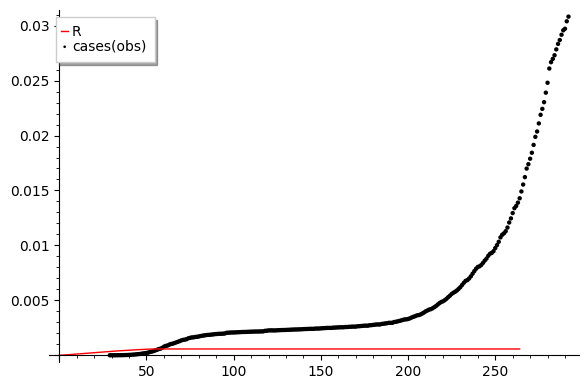

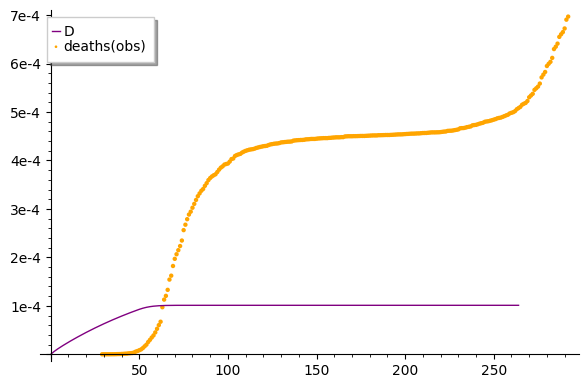

In [228]:
plot_results([res['lambda_'],
              res['alpha'],
              res['p'],
              res['theta'],
              res['gamma'],
              res['mu'],
              res['mu1'],
              res['mu2'],
              res['t1'],
              res['t2'],
              res['t0'],
             ])

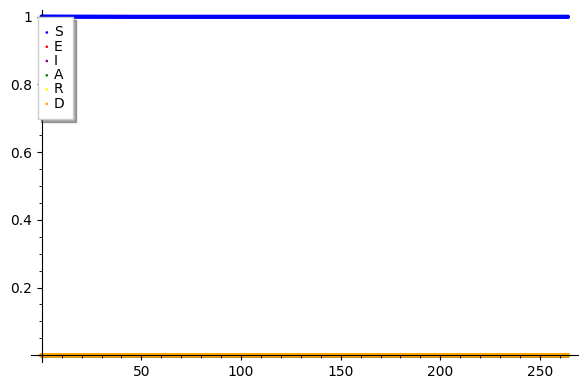

In [229]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='S')
    colors = ['blue','red','purple','green','yellow','orange']
    for i,var in enumerate(['E','I','A','R','D']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P)
plot_sol(T.solution)